<a href="https://colab.research.google.com/github/nickdhollman/MS-BAnDS-Google-Colab/blob/BAN-5743-Predictive-Analytics/Kazi_Cod_Kritik_Exercise_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import make_scorer

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving organics_Ex3.xlsx to organics_Ex3 (1).xlsx


In [ ]:
data = pd.read_excel("organics_Ex3.xlsx")
data.head(5)

,ID,DemAffl,DemAge,DemCluster,DemClusterGroup,DemGender,DemReg,DemTVReg,PromClass,PromSpend,PromTime,TargetBuy,TargetAmount
0,140,10,76,16.0,C,U,Midlands,Wales & West,Gold,16000.00,4,0,0.0
1,620,4,49,35.0,D,U,Midlands,Wales & West,Gold,6000.00,5,0,0.0
2,2313,11,68,4.0,A,F,Midlands,Midlands,Tin,0.01,8,0,0.0
3,2771,9,72,28.0,D,U,North,N West,Platinum,20759.81,3,0,0.0
4,3131,11,74,3.0,A,F,Midlands,East,Tin,0.01,8,0,0.0


In [ ]:
data = data.drop(columns=['ID','DemCluster','TargetAmount'])
data.head(5)

,DemAffl,DemAge,DemClusterGroup,DemGender,DemReg,DemTVReg,PromClass,PromSpend,PromTime,TargetBuy
0,10,76,C,U,Midlands,Wales & West,Gold,16000.00,4,0
1,4,49,D,U,Midlands,Wales & West,Gold,6000.00,5,0
2,11,68,A,F,Midlands,Midlands,Tin,0.01,8,0
3,9,72,D,U,North,N West,Platinum,20759.81,3,0
4,11,74,A,F,Midlands,East,Tin,0.01,8,0


In [ ]:
print("Null values per column before cleaning:")
print(data.isnull().sum())

Null values per column before cleaning:
DemAffl              0
DemAge               0
DemClusterGroup    674
DemGender            0
DemReg               0
DemTVReg             0
PromClass            0
PromSpend            0
PromTime             0
TargetBuy            0
dtype: int64


In [ ]:
data = data.dropna()
print("\nData shape after removing nulls:", data.shape)


Data shape after removing nulls: (21539, 10)



Summary Statistics for Continuous Features:
            DemAffl        DemAge      PromSpend      PromTime
count  21539.000000  21539.000000   21539.000000  21539.000000
mean       8.728539     53.866800    4423.630597      6.575978
std        3.335886     12.743585    7549.897892      4.648257
min        0.000000     18.000000       0.010000      0.000000
25%        6.000000     45.000000       0.010000      4.000000
50%        9.000000     54.000000    2000.000000      5.000000
75%       10.000000     64.000000    6000.000000      8.000000
max       34.000000     79.000000  296313.850000     39.000000


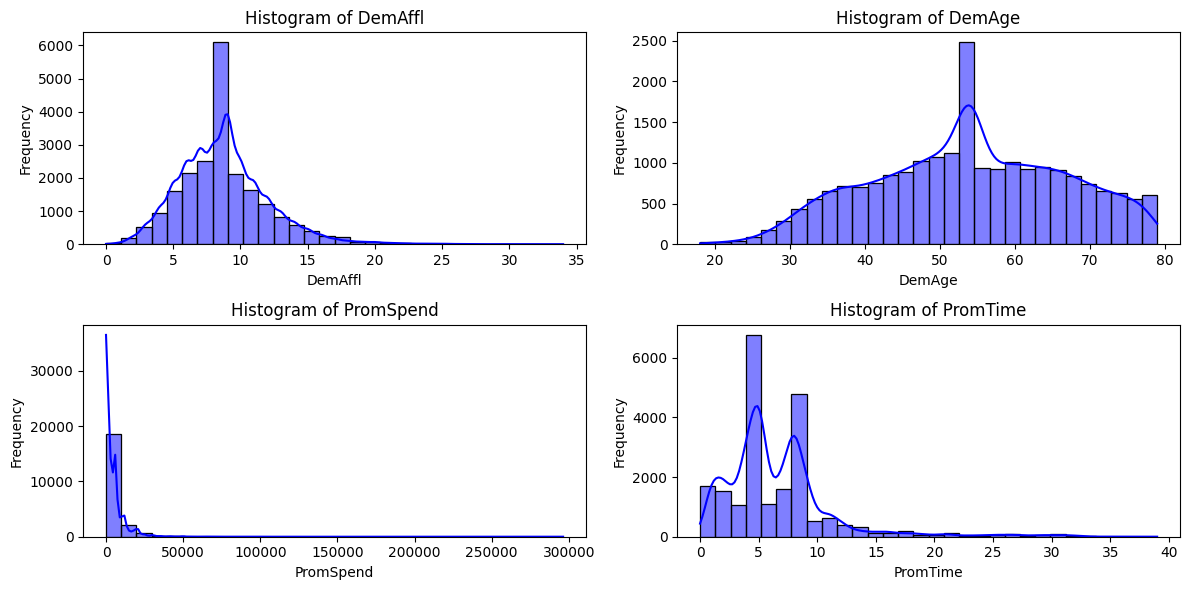

In [ ]:
print("\nSummary Statistics for Continuous Features:")
continuous_features = ["DemAffl", "DemAge", "PromSpend", "PromTime"]
print(data[continuous_features].describe())

plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
sns.histplot(data=data, x='DemAffl', bins=30, kde=True, color='blue', edgecolor='black')
plt.title(f'Histogram of {continuous_features[0]}')
plt.xlabel(f'{continuous_features[0]}')
plt.ylabel('Frequency')


plt.subplot(2, 2, 2)
sns.histplot(data=data, x='DemAge', bins=30, kde=True, color='blue', edgecolor='black')
plt.title(f'Histogram of {continuous_features[1]}')
plt.xlabel(f'{continuous_features[1]}')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sns.histplot(data=data, x=continuous_features[2], bins=30, kde=True, color='blue', edgecolor='black')
plt.title(f'Histogram of {continuous_features[2]}')
plt.xlabel(f'{continuous_features[2]}')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
sns.histplot(data=data, x=continuous_features[3], bins=30, kde=True, color='blue', edgecolor='black')
plt.title(f'Histogram of {continuous_features[3]}')
plt.xlabel(f'{continuous_features[3]}')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


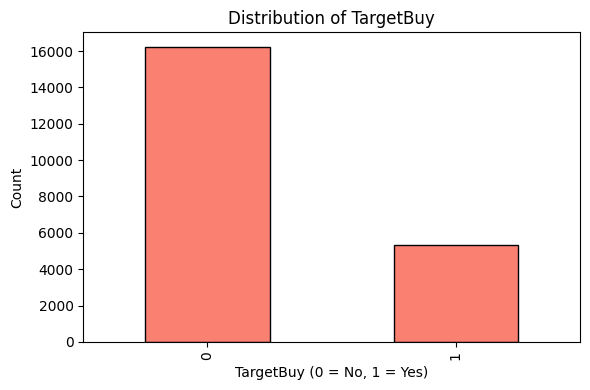

In [ ]:
plt.figure(figsize=(6, 4))
data["TargetBuy"].value_counts().plot(kind='bar', color='salmon', edgecolor='black')
plt.title("Distribution of TargetBuy")
plt.xlabel("TargetBuy (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Frequency')

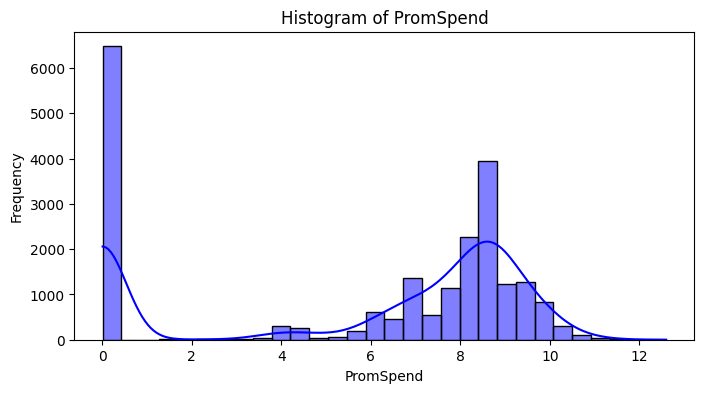

In [ ]:
data["PromSpend"] = np.log1p(data["PromSpend"])  # log1p handles zero values gracefully

plt.figure(figsize=(8, 4))
sns.histplot(data=data, x="PromSpend", bins=30, kde=True, color='blue', edgecolor='black')
plt.title(f'Histogram of {continuous_features[2]}')
plt.xlabel(f'{continuous_features[2]}')
plt.ylabel('Frequency')


In [ ]:
# feature lists
continuous_features = ["DemAffl", "DemAge", "PromSpend", "PromTime"]
categorical_features = ["DemClusterGroup", "DemGender", "DemReg", "DemTVReg", "PromClass"]
target = "TargetBuy"

In [ ]:
# custom midrange scaler function
def midrange_scaler(X):
    X = np.array(X, dtype=float)
    min_val = np.min(X, axis=0)
    max_val = np.max(X, axis=0)
    midrange = (min_val + max_val) / 2.0
    scale = (max_val - min_val) / 2.0
    # Avoid division by zero
    scale[scale == 0] = 1.0
    return (X - midrange) / scale

# Wrap the midrange scaler in a FunctionTransformer
midrange_transformer = FunctionTransformer(midrange_scaler)


# preprocessing pipeline:
preprocessor = ColumnTransformer(
    transformers=[
        ("cont", midrange_transformer, continuous_features),
        ("cat", OneHotEncoder(drop="first", sparse_output=False), categorical_features)])

In [ ]:
# dropping 'ID' and the target variable and target from the data
X = data.drop(columns=[target])
y = data[target].values

# preprocessing to the entire dataset
X_transformed = preprocessor.fit_transform(X)

In [ ]:
# Retrieving feature names for later use
ohe = preprocessor.named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = continuous_features + list(cat_feature_names)

print("\nTransformed feature shape:", X_transformed.shape)
print("Feature names:", feature_names)


Transformed feature shape: (21539, 30)
Feature names: ['DemAffl', 'DemAge', 'PromSpend', 'PromTime', 'DemClusterGroup_B', 'DemClusterGroup_C', 'DemClusterGroup_D', 'DemClusterGroup_E', 'DemClusterGroup_F', 'DemClusterGroup_U', 'DemGender_M', 'DemGender_U', 'DemReg_North', 'DemReg_Scottish', 'DemReg_South East', 'DemReg_South West', 'DemTVReg_C Scotland', 'DemTVReg_East', 'DemTVReg_London', 'DemTVReg_Midlands', 'DemTVReg_N East', 'DemTVReg_N Scot', 'DemTVReg_N West', 'DemTVReg_S & S East', 'DemTVReg_S West', 'DemTVReg_Wales & West', 'DemTVReg_Yorkshire', 'PromClass_Platinum', 'PromClass_Silver', 'PromClass_Tin']


In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_transformed, y, test_size=0.1, stratify=y, random_state=12345)

# Split the remaining data into training (70%) and validation (20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2222, stratify=y_train_val, random_state=12345)

print("\nShapes after splitting:")
print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)


Shapes after splitting:
Training set: (15077, 30)
Validation set: (4308, 30)
Test set: (2154, 30)


In [ ]:
# -------------------------
# Neural Network Models
# -------------------------
def build_model(n_hidden_layers, input_dim):
    model = Sequential()
    # First hidden layer
    model.add(Dense(16, activation="linear", input_dim=input_dim))
    # additional hidden layers
    for _ in range(n_hidden_layers - 1):
        model.add(Dense(16, activation="linear"))
    # Output layer: 1 neuron, linear activation
    model.add(Dense(1, activation="linear"))
    model.compile(optimizer="adam", loss="mse")
    return model

input_dim = X_train.shape[1]
# two models: NN3 (3 hidden layers) and NN6 (6 hidden layers)
model_nn3 = build_model(n_hidden_layers=3, input_dim=input_dim)
model_nn6 = build_model(n_hidden_layers=6, input_dim=input_dim)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

print("\nTraining NN3 model...")
history_nn3 = model_nn3.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val),
                            callbacks=[early_stop], verbose=1)

print("\nTraining NN6 model...")
history_nn6 = model_nn6.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val),
                            callbacks=[early_stop], verbose=1)



Training NN3 model...
Epoch 1/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.2330 - val_loss: 0.1528
Epoch 2/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1488 - val_loss: 0.1533
Epoch 3/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1496 - val_loss: 0.1508
Epoch 4/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1469 - val_loss: 0.1526
Epoch 5/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1482 - val_loss: 0.1498
Epoch 6/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1467 - val_loss: 0.1507
Epoch 7/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1480 - val_loss: 0.1502
Epoch 8/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1514 - val_loss: 0.1525
Epoch 9/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1508 - val_loss: 0.1507
Epoch 10/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1494 - val_loss: 0.1504

Training NN6 model...
Epoch 1/15
472/472 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1872 - val_loss: 0.1552
Epoch 2

In [ ]:
def evaluate_model(model, X_test, y_test):
    # continuous predictions from the model
    y_pred_cont = model.predict(X_test)
    # Threshold predictions at 0.5 to obtain binary outputs
    y_pred = (y_pred_cont >= 0.5).astype(int).ravel()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    try:
        auc = roc_auc_score(y_test, y_pred_cont)
    except ValueError:
        auc = None

    print("\nEvaluation Metrics:")
    print("Accuracy: {:.4f}".format(acc))
    print("Precision: {:.4f}".format(prec))
    print("Recall: {:.4f}".format(rec))
    print("F1-Score: {:.4f}".format(f1))
    if auc is not None:
        print("ROC-AUC: {:.4f}".format(auc))

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc}

print("\nEvaluating NN3 model on test set:")
metrics_nn3 = evaluate_model(model_nn3, X_test, y_test)

print("\nEvaluating NN6 model on test set:")
metrics_nn6 = evaluate_model(model_nn6, X_test, y_test)


Evaluating NN3 model on test set:
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Evaluation Metrics:
Accuracy: 0.7990
Precision: 0.7302
Recall: 0.2951
F1-Score: 0.4203
ROC-AUC: 0.7899

Evaluating NN6 model on test set:
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Evaluation Metrics:
Accuracy: 0.7953
Precision: 0.7333
Recall: 0.2688
F1-Score: 0.3934
ROC-AUC: 0.7908


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
36/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

<ipython-input-18-59385bac8a18>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lift_table = df.groupby("decile").agg(


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<ipython-input-18-59385bac8a18>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  lift_table = df.groupby("decile").agg(


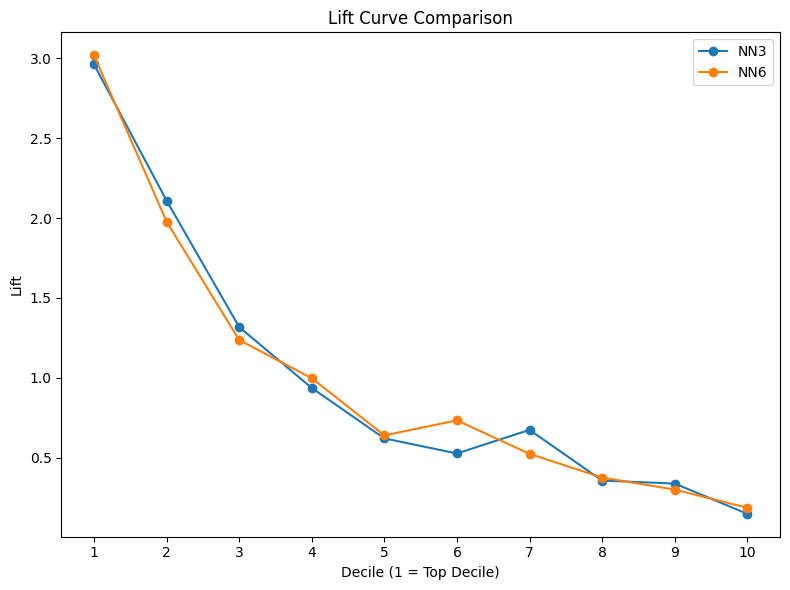

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_lift(y_true, y_scores, n_bins=10):

    df = pd.DataFrame({"y_true": y_true, "y_scores": y_scores.ravel()})
    df["decile"] = pd.qcut(-df["y_scores"], q=n_bins, labels=range(1, n_bins+1))

    lift_table = df.groupby("decile").agg(
        positive_rate=("y_true", "mean"),
        count=("y_true", "count")
    ).sort_index()  # sort by decile (1 to 10)

    overall_rate = df["y_true"].mean()
    lift_table["lift"] = lift_table["positive_rate"] / overall_rate
    return lift_table

def plot_lift_curves(lift_tables, model_names, n_bins=10):
    plt.figure(figsize=(8, 6))
    # x-axis: decile numbers from 1 (top decile) to n_bins (lowest decile)
    deciles = list(range(1, n_bins+1))

    for lt, name in zip(lift_tables, model_names):
        # Ensure the index is numeric decile values
        plt.plot(deciles, lt["lift"], marker='o', label=name)

    plt.xlabel("Decile (1 = Top Decile)")
    plt.ylabel("Lift")
    plt.title("Lift Curve Comparison")
    plt.xticks(deciles)
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()


y_scores_nn3 = model_nn3.predict(X_test)
lift_table_nn3 = compute_lift(y_test, y_scores_nn3, n_bins=10)

# Compute lift for model_nn6
y_scores_nn6 = model_nn6.predict(X_test)
lift_table_nn6 = compute_lift(y_test, y_scores_nn6, n_bins=10)

# Plot both lift curves in one figure
plot_lift_curves([lift_table_nn3, lift_table_nn6], ["NN3", "NN6"], n_bins=10)


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━

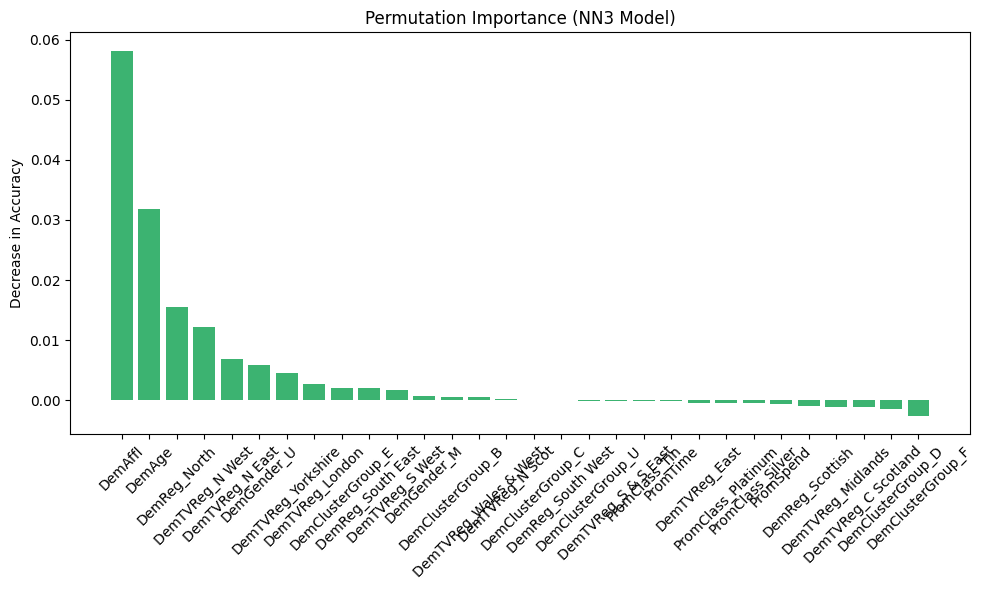

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin

# a scikit-learn compatible wrapper for your Keras model
class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, keras_model):
        self.keras_model = keras_model
        self.is_fitted_ = False

    def fit(self, X, y):
        # Dummy fit
        self.is_fitted_ = True
        return self

    def predict(self, X):
        # predictions from the Keras model and apply a threshold of 0.5
        preds = self.keras_model.predict(X)
        return (preds >= 0.5).astype(int).ravel()

    def score(self, X, y):
        # accuracy as the scoring metric
        return accuracy_score(y, self.predict(X))

    @property
    def classes_(self):
        return np.array([0, 1])

# Wrapping  trained Keras model
wrapped_model = KerasClassifierWrapper(model_nn3)
wrapped_model.fit(X_train, y_train)


accuracy_scorer = make_scorer(accuracy_score)

# Compute permutation importance
result = permutation_importance(wrapped_model, X_test, y_test, scoring=accuracy_scorer,
                                n_repeats=10, random_state=12345)

# Extract importances and sort them in descending order
importances = result.importances_mean
indices = np.argsort(importances)[::-1]

# Plot the permutation importance
plt.figure(figsize=(10, 6))
plt.title("Permutation Importance (NN3 Model)")
plt.bar(range(len(importances)), importances[indices], align="center", color='mediumseagreen')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.ylabel("Decrease in Accuracy")
plt.tight_layout()
plt.show()


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━

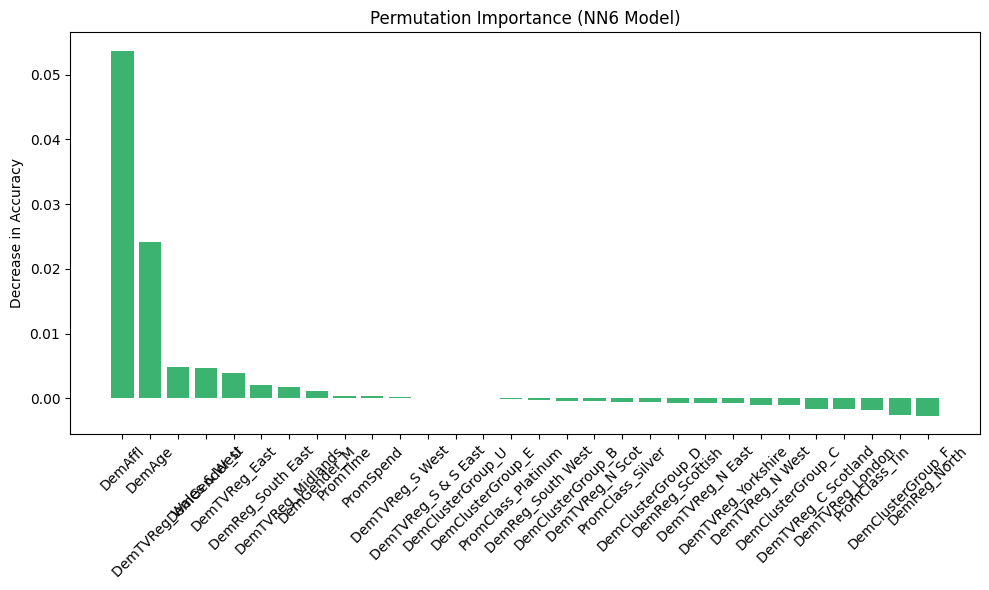

In [ ]:
wrapped_model = KerasClassifierWrapper(model_nn6)

wrapped_model.fit(X_train, y_train)

accuracy_scorer = make_scorer(accuracy_score)

result = permutation_importance(wrapped_model, X_test, y_test, scoring=accuracy_scorer,
                                n_repeats=10, random_state=12345)

importances = result.importances_mean
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Permutation Importance (NN6 Model)")
plt.bar(range(len(importances)), importances[indices], align="center", color='mediumseagreen')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.ylabel("Decrease in Accuracy")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    _estimator_type = "classifier"

    def __init__(self, keras_model):
        self.keras_model = keras_model

    def fit(self, X, y):
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array([f"feature_{i}" for i in range(X.shape[1])])
        self.classes_ = np.array([0, 1])  # Set classes as an attribute, not a property
        self.is_fitted_ = True
        return self

    def predict(self, X):
        raw_scores = self.keras_model.predict(X).ravel()
        return (raw_scores >= 0.5).astype(int)

    def predict_proba(self, X):
        raw_scores = self.keras_model.predict(X).ravel()
        # Convert raw scores to probabilities using a logistic transform
        probs_class1 = 1.0 / (1.0 + np.exp(-raw_scores))
        probs_class0 = 1.0 - probs_class1
        return np.vstack([probs_class0, probs_class1]).T

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━

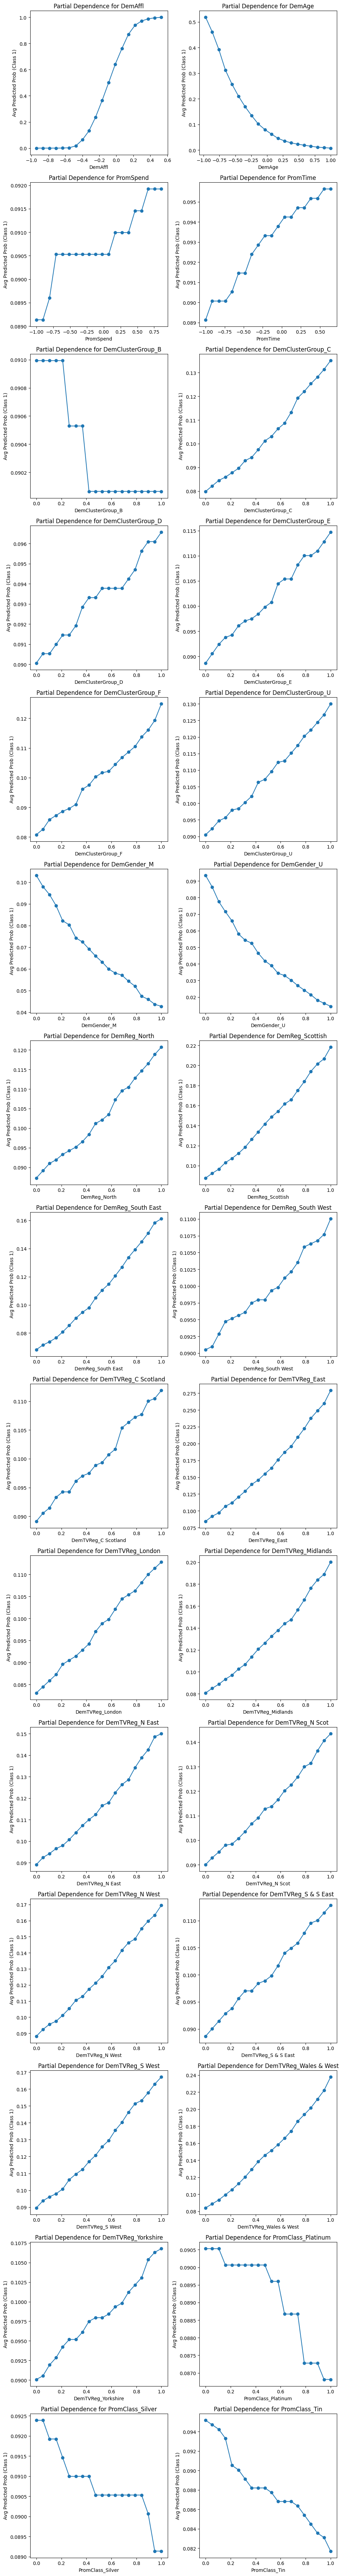

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

def compute_partial_dependence_manual(model, X, feature_idx, grid_resolution=20):

    X = np.array(X)  # ensure X is a numpy array
    feature_values = X[:, feature_idx]
    grid = np.linspace(np.min(feature_values), np.max(feature_values), grid_resolution)
    pd_values = []
    for val in grid:
        X_temp = X.copy()
        X_temp[:, feature_idx] = val  # set the entire column to this grid value
        preds = model.predict(X_temp)  # get probabilities for class 1
        pd_values.append(np.mean(preds))
    return grid, np.array(pd_values)

def plot_partial_dependence_all_features(model, X, feature_names, grid_resolution=20):

    X = np.array(X)
    n_features = X.shape[1]
    n_cols = 2  # number of subplots per row
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))
    # Flatten axes for easier iteration (if there's only one row/col, ensure axes is iterable)
    if n_features == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i in range(n_features):
        grid, pdp_values = compute_partial_dependence_manual(model, X, i, grid_resolution)
        ax = axes[i]
        ax.plot(grid, pdp_values, marker='o', linestyle='-')
        ax.set_xlabel(feature_names[i])
        ax.set_ylabel("Avg Predicted Prob (Class 1)")
        ax.set_title(f"Partial Dependence for {feature_names[i]}")

    # Remove extra subplots if any
    for j in range(n_features, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_partial_dependence_all_features(wrapped_model, X_test, feature_names, grid_resolution=20)


In [ ]:
!pip install pdpbox
from pdpbox import pdp, info_plots

# Convert X_test back to a DataFrame for easier feature referencing
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Partial Dependence Plot for DemAge
pdp_isolate = pdp.pdp_isolate(
    model=nn3_model,  # Trained NN3 model
    dataset=X_test_df,  # Test dataset
    model_features=X.columns,  # List of feature names
    feature='DemAge'  # Feature to analyze
)

# Plot the Partial Dependence Plot
pdp.pdp_plot(pdp_isolate, 'DemAge')
plt.title('Partial Dependence Plot for DemAge')
plt.xlabel('DemAge')
plt.ylabel('Predicted Probability of TargetBuy')
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 101.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 9.3 MB/s eta 0:00:00


ValueError: Shape of passed values is (2154, 30), indices imply (2154, 9)

In [ ]:
X_test

array([[-0.35294118,  0.90163934,  0.27041163, ...,  0.        ,
         1.        ,  0.        ],
       [-0.52941176,  0.04918033,  0.09598535, ...,  0.        ,
         1.        ,  0.        ],
       [-0.88235294,  0.18032787,  0.33480859, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.23529412, -0.40983607,  0.23497494, ...,  0.        ,
         1.        ,  0.        ],
       [-0.58823529,  0.31147541, -0.13023311, ...,  0.        ,
         1.        ,  0.        ],
       [-0.47058824, -0.01639344, -0.14763188, ...,  0.        ,
         1.        ,  0.        ]])

In [ ]:
!pip install pdpbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.8/35.8 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 7.2 MB/s eta 0:00:00


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


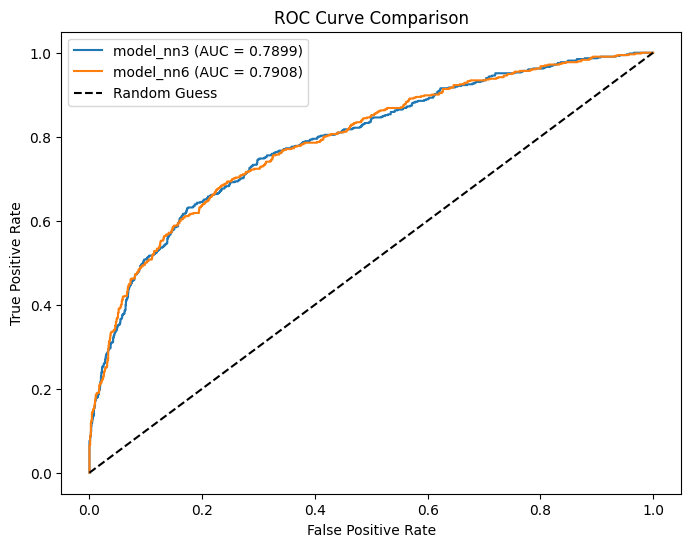

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curves(models, model_names, X_test, y_test):
    plt.figure(figsize=(8, 6))

    for model, name in zip(models, model_names):
        y_scores = model.predict(X_test).ravel()
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        # Compute AUC
        auc_val = roc_auc_score(y_test, y_scores)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_val:.4f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend(loc="best")
    plt.show()


plot_roc_curves(
    models=[model_nn3, model_nn6],
    model_names=["model_nn3", "model_nn6"],
    X_test=X_test,
    y_test=y_test
)
